In [3]:
import healpy, pyfits

In [4]:

phfile = '/data/fermi_data_1-8-14/photon/lat_ph_merged_ALL_BOTH_2.fits' # Photon filename

# Spatial Binning Parameters
nside = 256       # Number of sides in healpix grid

# Spectral Binning Parameters
E_min,E_max=5e2,5e5  # Min/Max energies for recursive spectral binning
n_bins=20   # Number of spectal bins
gamma=1.45  # Spectral binning recursion index
bin_edges  =  [300,350,400,450,500] # low energy bin edges

#--------------------------------------------------------------------
# End Parameters
#--------------------------------------------------------------------


#--------------------------------------------------------------------
# Recursively generate bin edges
Ej = 500.
for j in range(n_bins):
    # Eqn 2.3 (1409.0042)
    Ej = (Ej**(1-gamma) - (E_min**(1-gamma)-E_max**(1-gamma))/n_bins)**(1/(1-gamma))
    bin_edges += [Ej,]
print bin_edges
#--------------------------------------------------------------------
# Load Fermi Data
data = pyfits.open(phfile)[1].data

#--------------------------------------------------------------------
# Perform Spectral binning
bin_idx = [] # indices of the photons in each spectral bin.
for i in range(len(bin_edges)-1):
    bin_low, bin_high = bin_edges[i], bin_edges[i+1]
    idx = np.where( (data['ENERGY']>bin_low) & (data['ENERGY']<bin_high) )[0]
    bin_idx.append(idx)


# Now for each spectral bin, form the list of healpix pixels.
binned_data = np.zeros(shape=(len(bin_idx),12*nside**2)) # master list of bin counts. 1st index is spectral, 2nd is pixel_number
for i in range(binned_data.shape[0]):
    # Convert sky coords to healpix pixel number 
    idx = bin_idx[i]
    pix = healpy.ang2pix(nside=nside,theta=np.deg2rad(data['B'][idx])+np.pi/2.,phi=np.deg2rad(data['L'][idx]))
    binned_data[i] = np.bincount(pix, minlength=12*nside**2)
    


[300, 350, 400, 450, 500, 557.4511962326, 624.9931144482831, 705.0811841511901, 800.9547380631948, 916.9544789959854, 1058.9994895010252, 1235.32183584898, 1457.6298200740125, 1743.0094229290717, 2117.148088832825, 2620.038055486477, 3316.5858204132596, 4317.5724796525965, 5824.226374320851, 8232.171915073328, 12404.648624640446, 20517.115667189668, 39361.808463774716, 99337.18520898951, 499999.9999999654]


In [8]:
#--------------------------------------------------------------------
# Generate square mask with hole
#--------------------------------------------------------------------
b_min, b_max = -20,20 # Defines the outer boundary for latitude in degrees
l_min, l_max = -20,20 # Defines the outer boundary for longitude in degrees 
plane_mask = 2   # Choose the mask for the galactic plane ( i.e. mask |b|<plane_mask )
fgl_path = '/data/gll_psc_v08.fit' # 2FGL Path
fgl_flux_cut = 1e-9 # min flux to include 2FGL sources


# Find central sky position for each healpix pixel
b_pix, l_pix = np.rad2deg(healpy.pix2ang(nside=nside, ipix=np.arange(12*nside**2)))
b_pix -= 90. # shift 

mask = np.zeros(shape=12*nside**2)

idx = np.where( ((l_pix<l_max) | (l_pix>(l_min+360)))
          & (b_pix<b_max) & (b_pix>b_min)
          & (np.abs(b_pix)>plane_mask) )[0]
mask[idx] = 1. # Set unmasked elements to 1 



[ -6.72805023e+01  -7.19966965e+01   7.52291991e-04 ...,  -7.80167389e+01
   5.48612499e+00   3.39290190e+00] [  88.82917786  334.07559204  117.31168365 ...,   12.87561893  118.04753113
  117.63690948]


<function healpy.pixelfunc.ang2pix>

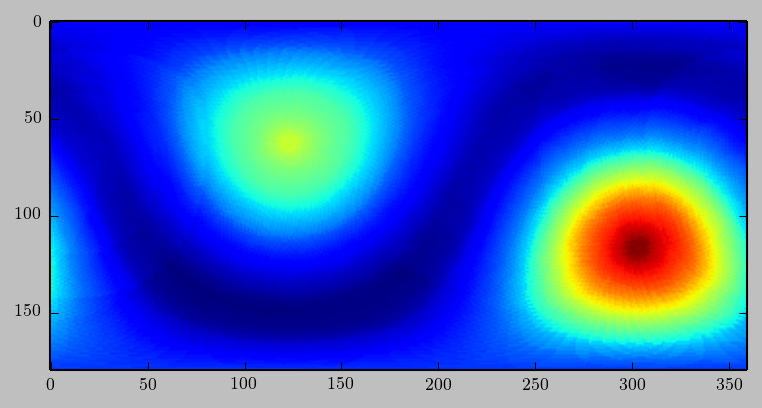

In [29]:
#--------------------------------------------------------------------
# Generate point source mask
#--------------------------------------------------------------------

# load exposure map
hdu = pyfits.open('/data/fermi_data_1-8-14/gtexpcube2_ALL_BOTH')

def GetExpMap(E,l,b):
    '''Returns a vector of the effective area given the energy and two input vectors.  E is in MeV'''    
    
    # Find which energy bin we are interested in 
    Ebin = int(np.round((np.log(E)-hdu[0].header['CRVAL3'])/hdu[0].header['CDELT3']))
    if Ebin>=hdu[0].header['NAXIS3']: Ebin=hdu[0].header['NAXIS3']-1

    # convert 0-360 to -180-180
    idx = np.where(l>180)[0]
    l[idx] = l[idx]-360
    # Find lat/lon bin on expmap 
    l_bin = np.round((l-hdu[0].header['CRVAL1'])/hdu[0].header['CDELT1']+hdu[0].header['CRPIX1']).astype(np.int32)
    b_bin = np.round((b-hdu[0].header['CRVAL2'])/hdu[0].header['CDELT2']+hdu[0].header['CRPIX2']).astype(np.int32)
    # Return the exposure map in cm*s
    return hdu[0].data[Ebin,b_bin,l_bin]
    
# Test the Get Exp Map Routine
test = np.zeros(shape=(180,360))
import Tools
reload(Tools)
for i in range(-90,90):
    test[i+90] = Tools.GetExpMap(500,np.arange(360),i)
plt.imshow(np.roll(test,180,axis=1))


fgl_hdu = pyfits.open(fgl_path)
print fgl_hdu[1].data['GLAT'], fgl_hdu[1].data['GLON']

healpy.ang2pix



Filename: /data/fermi_data_1-8-14/gtbin_ALL_BOTH.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      86   (2881, 1441, 24)   int32   
1    EBOUNDS     BinTableHDU     43   24R x 3C     [I, 1E, 1E]   
2    GTI         BinTableHDU     50   32441R x 2C   [D, D]   


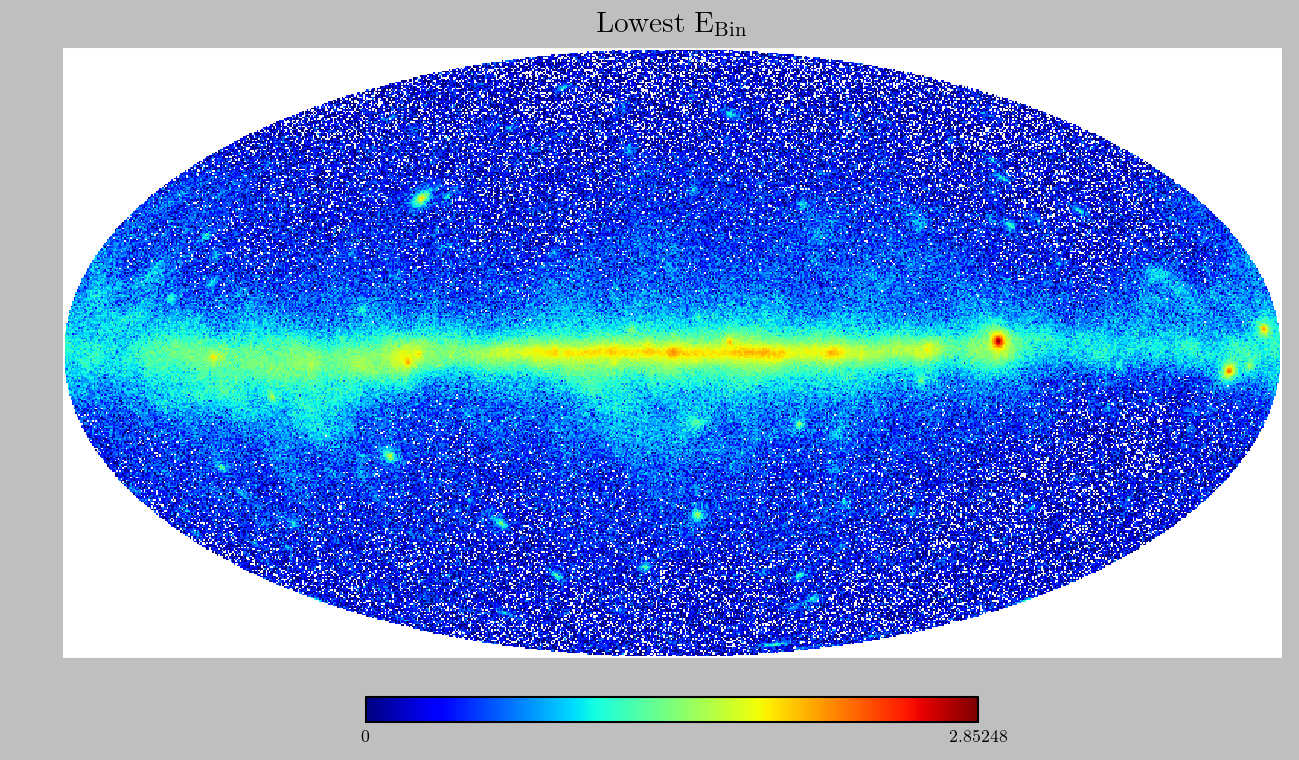

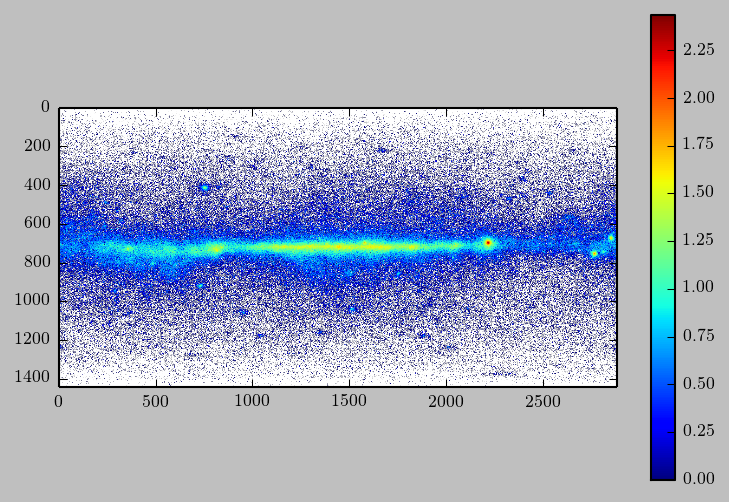

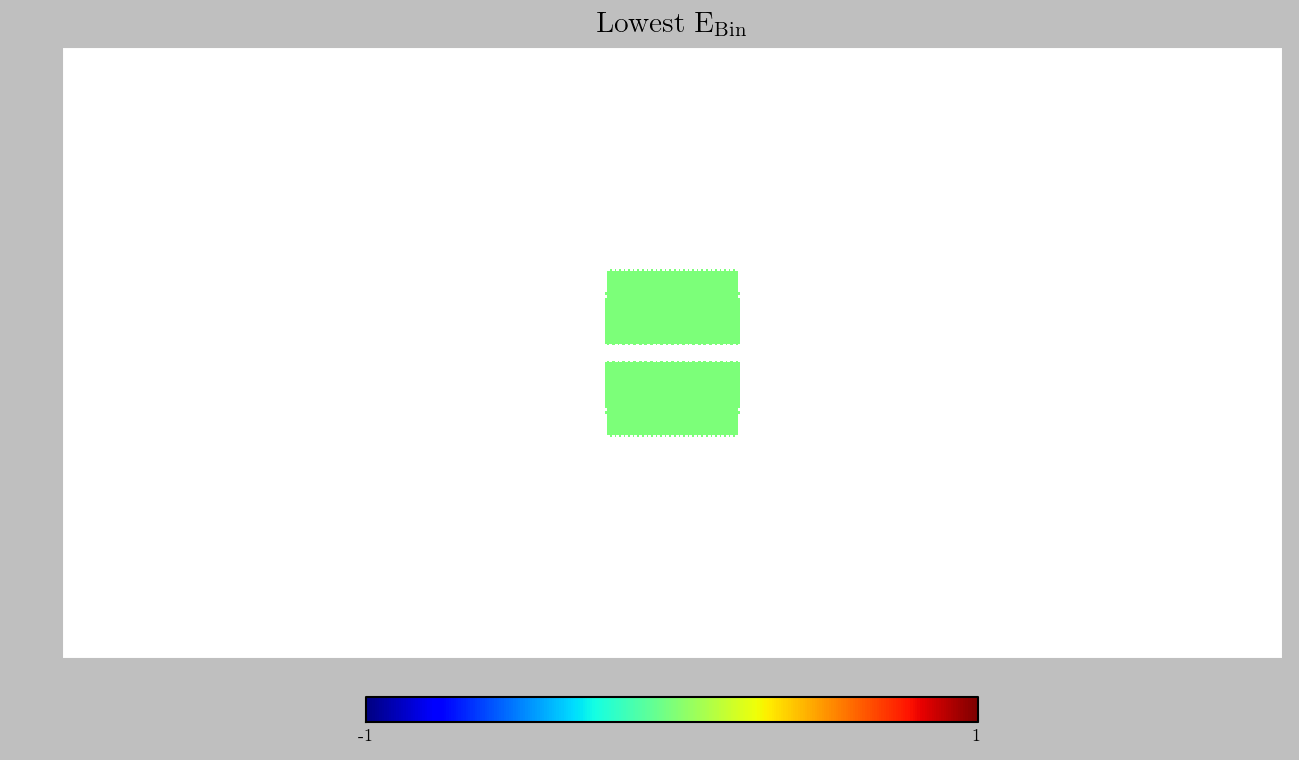

In [41]:
hdu2 = pyfits.open('/data/fermi_data_1-8-14/gtbin_ALL_BOTH.fits')
hdu2.info()

healpy.mollview(np.log10(binned_data[0]), title=r"Lowest E$_{\rm Bin}$")
plt.show()
plt.imshow(np.log10(hdu2[0].data[0]))
plt.colorbar()
plt.show()
healpy.mollview(np.log(mask), title=r"Lowest E$_{\rm Bin}$")





In [25]:
import Analysis
reload(Analysis)
analysis = Analysis.Analysis()

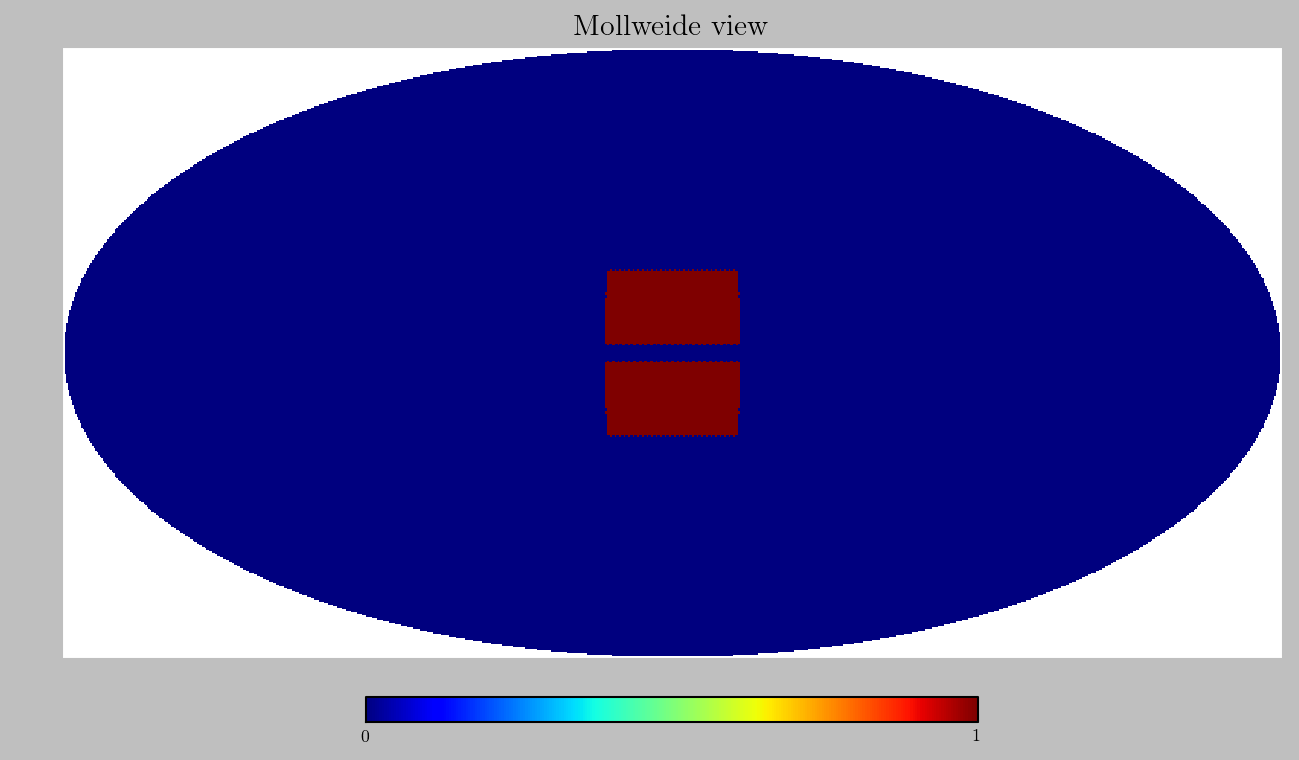

In [26]:
healpy.mollview(analysis.GenSquareMask(l_range=[-20,20], b_range=[-20,20], plane_mask=2))

In [140]:
for i in range(len(bin_edges)-1):
    print bin_edges[i], bin_edges[i+1]

300 350
350 400
400 450
450 500
500 557.451196233
557.451196233 624.993114448
624.993114448 705.081184151
705.081184151 800.954738063
800.954738063 916.954478996
916.954478996 1058.9994895
1058.9994895 1235.32183585
1235.32183585 1457.62982007
1457.62982007 1743.00942293
1743.00942293 2117.14808883
2117.14808883 2620.03805549
2620.03805549 3316.58582041
3316.58582041 4317.57247965
4317.57247965 5824.22637432
5824.22637432 8232.17191507
8232.17191507 12404.6486246
12404.6486246 20517.1156672
20517.1156672 39361.8084638
39361.8084638 99337.185209
99337.185209 500000.0


(25, 1441, 2881)


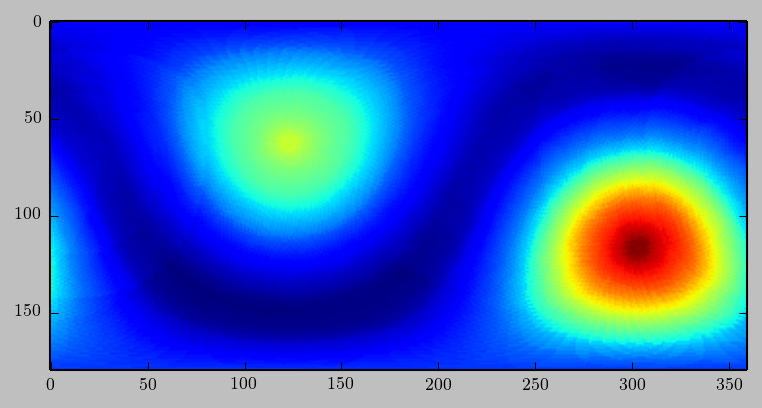

('SIMPLE', True, 'file does conform to FITS standard')
('BITPIX', -32, 'number of bits per data pixel')
('NAXIS', 3, 'number of data axes')
('NAXIS1', 2881, 'length of data axis 1')
('NAXIS2', 1441, 'length of data axis 2')
('NAXIS3', 25, 'length of data axis 3')
('EXTEND', True, 'FITS dataset may contain extensions')
('COMMENT', "  FITS (Flexible Image Transport System) format is defined in 'Astronomy", '')
('COMMENT', "  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H", '')
('HDUNAME', 'PRIMARY', '')
('CHECKSUM', 'boVSdmSQbmSQbmSQ', 'HDU checksum updated 2014-11-19T07:56:19')
('DATASUM', '2075017166', 'data unit checksum updated 2014-11-19T07:56:18')
('TELESCOP', 'GLAST', '')
('INSTRUME', 'LAT', '')
('DATE', '2014-11-19T07:56:18.0000', '')
('DATE-OBS', '2008-08-04T15:43:36.4941', '')
('DATE-END', '2014-06-03T02:12:39.9992', '')
('CRVAL1', 0.0, '')
('CRPIX1', 1441.0, '')
('CDELT1', -0.125, '')
('CRVAL2', 0.0, '')
('CRPIX2', 721.0, '')
('CDELT2', 0.125, '')
('CTYP

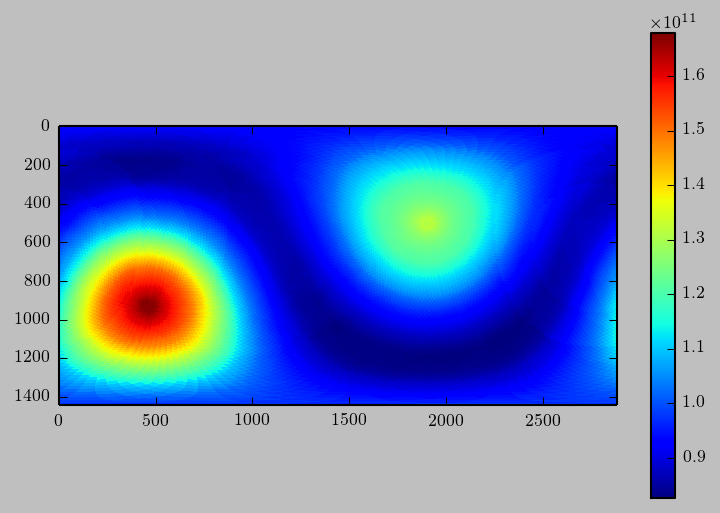

<matplotlib.colorbar.Colorbar instance at 0x7fbaa38f6cf8>

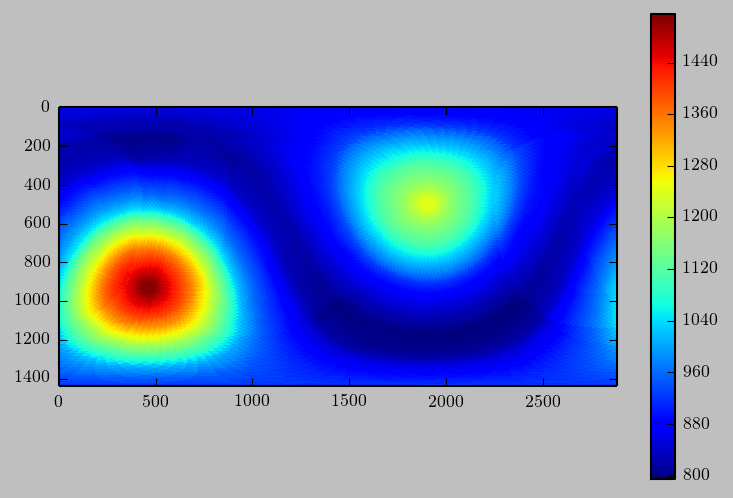

In [210]:
print hdu[0].header.cards
im = plt.imshow(hdu[0].data[0])
plt.colorbar(im)
plt.show()
im = plt.imshow(hdu[0].data[20]/(423454362.999225-239557417.494176))
plt.colorbar(im)




In [216]:
len(fgl_hdu[1].data['GLAT'])

1873

-c:4: RuntimeWarning: divide by zero encountered in log10


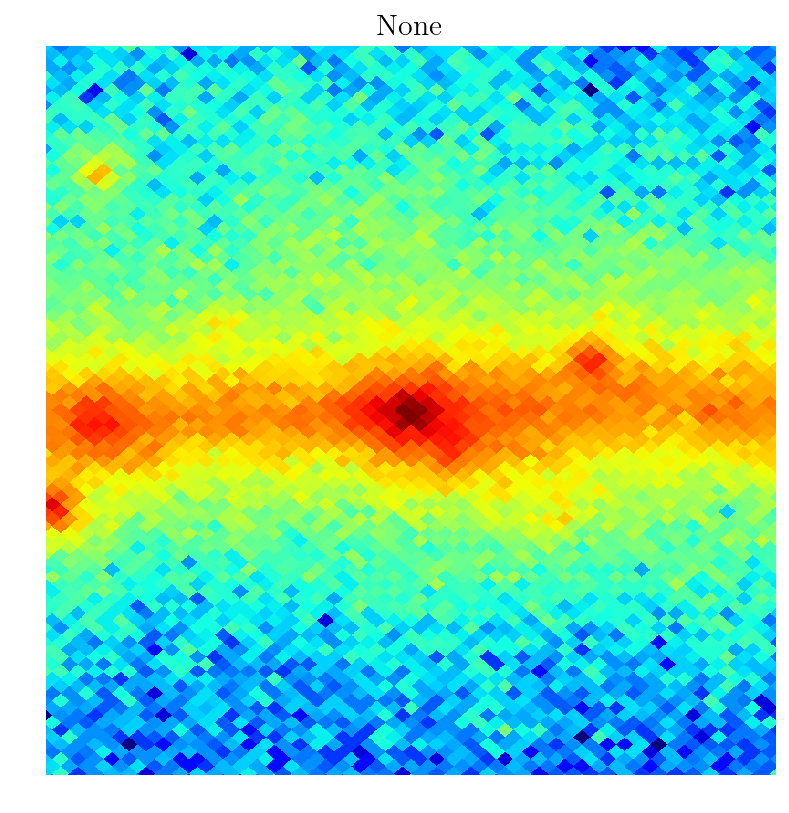

In [6]:
import healpy
plt.figure(figsize=(4,4))
photons = np.load('binned_photons_P8R2_CLEAN_V6_calore.npy')
healpy.cartview(np.log10(photons[8]), latra=[-7.5,7.5], lonra=[-7.5,7.5], cbar=False, title=None)